June 27th 2024  
Use the weights to calculate the average connectivity profile in various ways and save them.

In [1]:
import sys, os, glob
import datetime, time

import numpy as np
from numpy import linalg as nla
#import scipy.linalg as sla
import numpy.random as nrd

# import scipy.stats as sst

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import scipy.io as sio
from scipy.stats import wilcoxon
from scipy.stats import binom

from collections import defaultdict

gen_fns_dir = os.path.abspath('../shared')
sys.path.append(gen_fns_dir)
from general_file_fns import load_pickle_file, save_pickle_file
import conn_data_analysis_fns as cdaf

curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'
#sd=int((time.time()%1)*(2**31))
# rng = nrd.default_rng(sd)
# print('Seed= ',sd)

In [5]:
data_path = '/Users/tianhaoqiu/Desktop/2025_04_tq_share/delta7_rec_matrices/'
fname = 'delta7_delta7_connections_rec_matrices_with_normalized_weights.p'
conn_matrices = load_pickle_file(data_path + fname)


In [6]:
neuron_list = conn_matrices['neuron_list']
subtype_list = conn_matrices['subtype_list']
subtype_idx = conn_matrices['subtype_idx']
raw_conn_matrix = conn_matrices['raw_conn_matrix']
norm_conn_matrix = conn_matrices['norm_conn_matrix']

['Delta7(PB15)_L1L9R8_R', 'Delta7(PB15)_L2R7_R', 'Delta7(PB15)_L3R6_R', 'Delta7(PB15)_L4R5_R', 'Delta7(PB15)_L4R6_R', 'Delta7(PB15)_L5R4_L', 'Delta7(PB15)_L6R3_L', 'Delta7(PB15)_L6R4_L', 'Delta7(PB15)_L7R2_L', 'Delta7(PB15)_L7R3_L', 'Delta7(PB15)_L8R1R9_L']


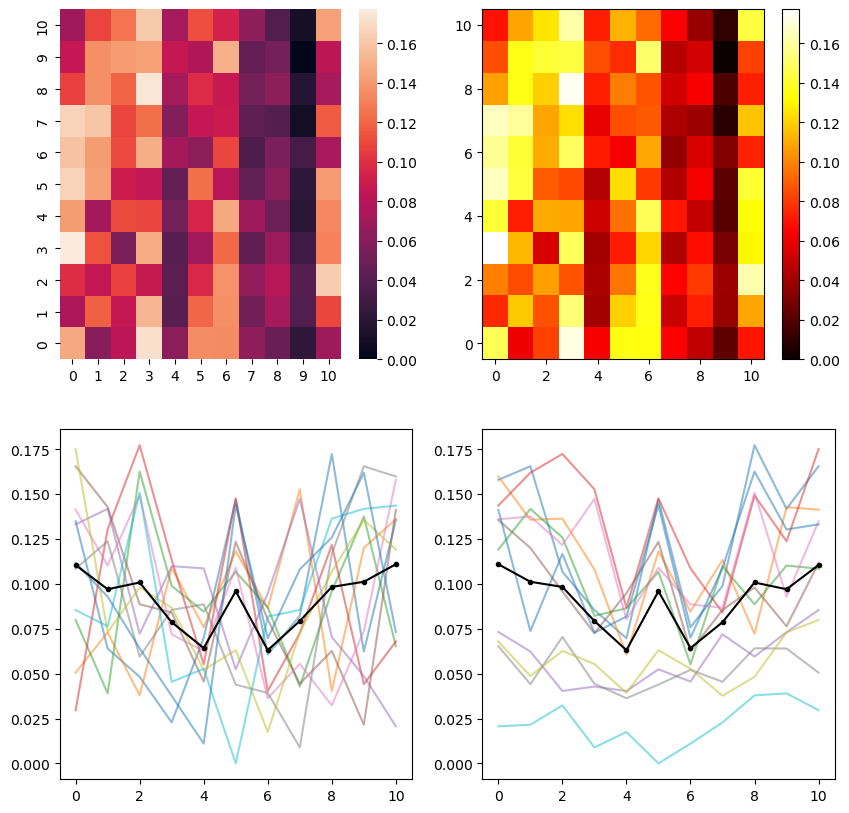

In [7]:
# Get aggregated connectivity at subtype-subtype level
print(subtype_list)
subtype_rec_matrix = cdaf.gather_over_subtype(norm_conn_matrix.T, subtype_list, subtype_idx)
n_subtypes = len(subtype_rec_matrix)
# Each row corresponds to a postsynaptic aggregate neuron
subtype_rec_matrix_shifted_rows = cdaf.diag_align(subtype_rec_matrix, offset=5)
subtype_rec_matrix_shifted_cols = cdaf.diag_align(subtype_rec_matrix.T, offset=5)
subtype_avg_input = np.mean(subtype_rec_matrix_shifted_rows, axis=0)
subtype_avg_output = np.mean(subtype_rec_matrix_shifted_cols, axis=0)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.heatmap(subtype_rec_matrix, cmap="rocket", ax=ax[0,0])
ax[0,0].invert_yaxis()
p = ax[0,1].imshow(subtype_rec_matrix, aspect='auto', interpolation='nearest', origin='lower', cmap='hot')
fig.colorbar(p, ax=ax[0, 1])

for i in range(n_subtypes):
    ax[1,0].plot(np.arange(n_subtypes), subtype_rec_matrix_shifted_rows[i], alpha=0.5)
    ax[1,1].plot(np.arange(n_subtypes), subtype_rec_matrix_shifted_cols[i], alpha=0.5)

ax[1,0].plot(np.arange(n_subtypes), subtype_avg_input, color='k', marker='.')
ax[1,1].plot(np.arange(n_subtypes), subtype_avg_output, color='k', marker='.')


The results above are in subtype space. There are 11 subtypes, but these innervate overlapping glomeruli. We know want to move into glomerular space, which is hopefully more tightly coupled to angle space.

In [8]:
# We want to combine subtypes that project to the same left glomerulus and, separately, subtypes that project 
# to the same right glomerulus.
left_glom_idx = defaultdict(list)
right_glom_idx = defaultdict(list)

for subtype in subtype_list:
    rel_nrn_idx = subtype_idx[subtype]
    x = subtype[13:] # Get rid of first part of string
    l_glom = x.partition('R')[0]
    r_glom = ('R' + x.partition('R')[2])[:-2]
    print(subtype, l_glom, r_glom, rel_nrn_idx)
    
    left_glom_idx[l_glom].extend(rel_nrn_idx)
    right_glom_idx[r_glom].extend(rel_nrn_idx)

left_glom_list = sorted(left_glom_idx.keys())
right_glom_list = sorted(right_glom_idx.keys())


Delta7(PB15)_L1L9R8_R L1L9 R8 [0, 1, 2, 3, 4]
Delta7(PB15)_L2R7_R L2 R7 [5, 6, 7, 8, 9]
Delta7(PB15)_L3R6_R L3 R6 [10, 11, 12, 13]
Delta7(PB15)_L4R5_R L4 R5 [14, 15, 16, 17, 18]
Delta7(PB15)_L4R6_R L4 R6 [19, 20]
Delta7(PB15)_L5R4_L L5 R4 [21, 22, 23, 24, 25]
Delta7(PB15)_L6R3_L L6 R3 [26, 27, 28, 29, 30]
Delta7(PB15)_L6R4_L L6 R4 [31, 32]
Delta7(PB15)_L7R2_L L7 R2 [33, 34, 35]
Delta7(PB15)_L7R3_L L7 R3 [36]
Delta7(PB15)_L8R1R9_L L8 R1R9 [37, 38, 39, 40, 41]


In [9]:
# Look at which neurons made it into which bucket, and how many there are
for k, v in left_glom_idx.items():
    print(k, '\t', v, '\t', len(v))
print('\n')
for k, v in right_glom_idx.items():
    print(k, '\t', v, '\t', len(v))
    

L1L9 	 [0, 1, 2, 3, 4] 	 5
L2 	 [5, 6, 7, 8, 9] 	 5
L3 	 [10, 11, 12, 13] 	 4
L4 	 [14, 15, 16, 17, 18, 19, 20] 	 7
L5 	 [21, 22, 23, 24, 25] 	 5
L6 	 [26, 27, 28, 29, 30, 31, 32] 	 7
L7 	 [33, 34, 35, 36] 	 4
L8 	 [37, 38, 39, 40, 41] 	 5


R8 	 [0, 1, 2, 3, 4] 	 5
R7 	 [5, 6, 7, 8, 9] 	 5
R6 	 [10, 11, 12, 13, 19, 20] 	 6
R5 	 [14, 15, 16, 17, 18] 	 5
R4 	 [21, 22, 23, 24, 25, 31, 32] 	 7
R3 	 [26, 27, 28, 29, 30, 36] 	 6
R2 	 [33, 34, 35] 	 3
R1R9 	 [37, 38, 39, 40, 41] 	 5


Now make the same plots of recurrent connectivity and average profile for both the left and right glomerular connectivity.

['L1L9', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']


[Text(0.5, 80.7222222222222, 'Difference in left glomerulus'),
 Text(87.59722222222221, 0.5, 'Conn strength (normalized)')]

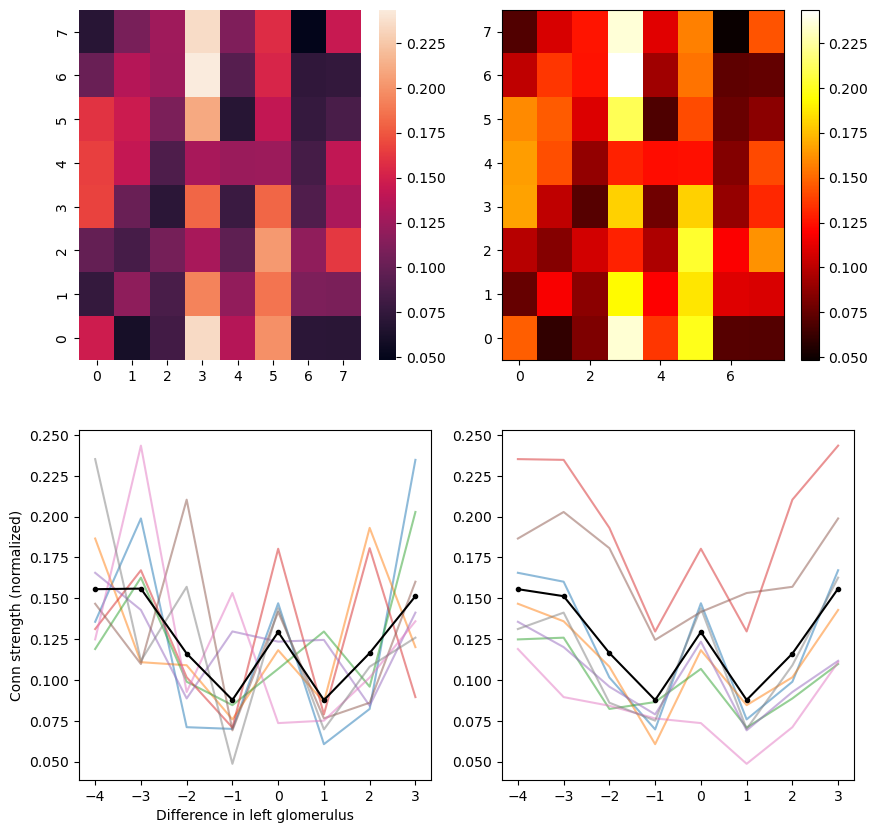

In [10]:
# Get aggregated connectivity by left glomerulus
print(left_glom_list)
n_left_gloms = len(left_glom_list)
x_ax_lg = np.arange(-4, 4)
left_glom_rec_matrix = cdaf.gather_over_subtype(norm_conn_matrix.T, left_glom_list, left_glom_idx)

# Each row corresponds to a postsynaptic aggregate neuron
left_glom_rec_matrix_shifted_rows = cdaf.diag_align(left_glom_rec_matrix, offset=4)
left_glom_rec_matrix_shifted_cols = cdaf.diag_align(left_glom_rec_matrix.T, offset=4)
left_glom_avg_input = np.mean(left_glom_rec_matrix_shifted_rows, axis=0)
left_glom_avg_output = np.mean(left_glom_rec_matrix_shifted_cols, axis=0)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.heatmap(left_glom_rec_matrix, cmap="rocket", ax=ax[0,0])
ax[0,0].invert_yaxis()
p = ax[0,1].imshow(left_glom_rec_matrix, aspect='auto', interpolation='nearest', origin='lower', cmap='hot')
fig.colorbar(p, ax=ax[0, 1])

for i in range(n_left_gloms):
    ax[1,0].plot(x_ax_lg, left_glom_rec_matrix_shifted_rows[i], alpha=0.5)
    ax[1,1].plot(x_ax_lg, left_glom_rec_matrix_shifted_cols[i], alpha=0.5)

ax[1,0].plot(x_ax_lg, left_glom_avg_input, color='k', marker='.')
ax[1,1].plot(x_ax_lg, left_glom_avg_output, color='k', marker='.')
ax[1,0].set(xlabel='Difference in left glomerulus', ylabel='Conn strength (normalized)')

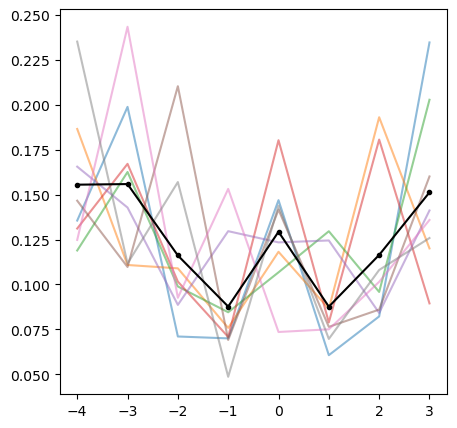

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for i in range(n_left_gloms):
    ax.plot(x_ax_lg, left_glom_rec_matrix_shifted_rows[i], alpha=0.5)

ax.plot(x_ax_lg, left_glom_avg_input, color='k', marker='.')
# ax[1,0].set(xlabel='Difference in left glomerulus', ylabel='Conn strength (normalized)')
plt.savefig('left_glom_delta7_profile.pdf')

['R1R9', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']


[Text(0.5, 80.7222222222222, 'Difference in right glomerulus'),
 Text(87.59722222222221, 0.5, 'Conn strength (normalized)')]

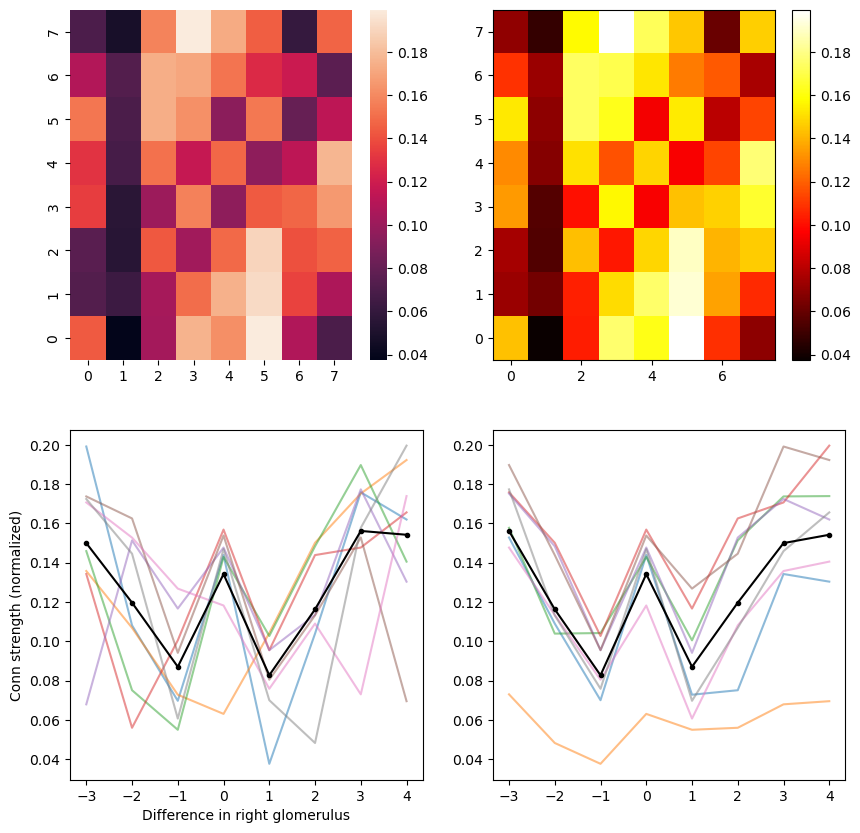

In [12]:
# Get aggregated connectivity by right glomerulus
print(right_glom_list)
n_right_gloms = len(right_glom_list)
x_ax_rg = np.arange(-3, 5)
right_glom_rec_matrix = cdaf.gather_over_subtype(norm_conn_matrix.T, right_glom_list, right_glom_idx)

# Each row corresponds to a postsynaptic aggregate neuron
right_glom_rec_matrix_shifted_rows = cdaf.diag_align(right_glom_rec_matrix, offset=3)
right_glom_rec_matrix_shifted_cols = cdaf.diag_align(right_glom_rec_matrix.T, offset=3)
right_glom_avg_input = np.mean(right_glom_rec_matrix_shifted_rows, axis=0)
right_glom_avg_output = np.mean(right_glom_rec_matrix_shifted_cols, axis=0)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
sns.heatmap(right_glom_rec_matrix, cmap="rocket", ax=ax[0,0])
ax[0,0].invert_yaxis()
p = ax[0,1].imshow(right_glom_rec_matrix, aspect='auto', interpolation='nearest', origin='lower', cmap='hot')
fig.colorbar(p, ax=ax[0, 1])

for i in range(n_right_gloms):
    ax[1,0].plot(x_ax_rg, right_glom_rec_matrix_shifted_rows[i], alpha=0.5)
    ax[1,1].plot(x_ax_rg, right_glom_rec_matrix_shifted_cols[i], alpha=0.5)

ax[1,0].plot(x_ax_rg, right_glom_avg_input, color='k', marker='.')
ax[1,1].plot(x_ax_rg, right_glom_avg_output, color='k', marker='.')
ax[1,0].set(xlabel='Difference in right glomerulus', ylabel='Conn strength (normalized)')

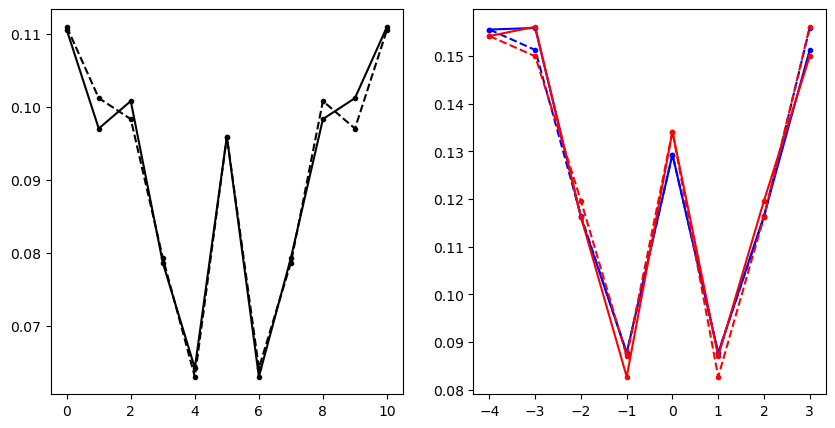

In [13]:
# All together
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(np.arange(n_subtypes), subtype_avg_input, color='k', marker='.')
ax[0].plot(np.arange(n_subtypes), subtype_avg_output, color='k', marker='.', ls='--')

ax[1].plot(x_ax_lg, left_glom_avg_input, color='b', marker='.')
ax[1].plot(x_ax_lg, left_glom_avg_output, color='b', marker='.', ls='--')

ax[1].plot(x_ax_lg, right_glom_avg_input[::-1], color='r', marker='.')
ax[1].plot(x_ax_lg, right_glom_avg_output[::-1], color='r', marker='.', ls='--')

In [10]:
n_left_gloms

8

In [11]:
n_right_gloms

8

In [12]:
glom_avg_input = (left_glom_avg_input + right_glom_avg_input[::-1])/2.
glom_avg_output = (left_glom_avg_output + right_glom_avg_output[::-1])/2.
n_gloms = n_left_gloms

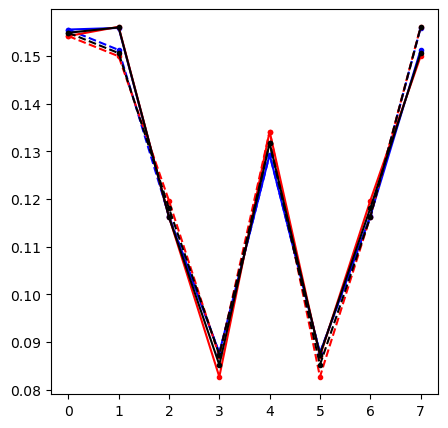

In [13]:
# All together
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.arange(n_left_gloms), left_glom_avg_input, color='b', marker='.')
ax.plot(np.arange(n_left_gloms), left_glom_avg_output, color='b', marker='.', ls='--')

ax.plot(np.arange(n_right_gloms), right_glom_avg_input[::-1], color='r', marker='.')
ax.plot(np.arange(n_right_gloms), right_glom_avg_output[::-1], color='r', marker='.', ls='--')

ax.plot(np.arange(n_gloms), glom_avg_input, color='k', marker='.')
ax.plot(np.arange(n_gloms), glom_avg_output, color='k', marker='.', ls='--')

In [14]:
left_glom_list

['L1L9', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']

In [15]:
right_glom_list[::-1]

['R8', 'R7', 'R6', 'R5', 'R4', 'R3', 'R2', 'R1R9']

In [16]:
to_save = conn_matrices
to_save.update({'subtype_rec_matrix' : subtype_rec_matrix, 'subtype_avg_input' : subtype_avg_input, 
               'subtype_avg_output' : subtype_avg_output, 'left_glom_list' : left_glom_list, 
               'right_glom_list' : right_glom_list, 'left_glom_idx' : left_glom_idx, 
                'right_glom_idx' : right_glom_idx, 'left_glom_rec_matrix' : left_glom_rec_matrix,
               'left_glom_avg_input' : left_glom_avg_input, 'left_glom_avg_output' : left_glom_avg_output, 
                'right_glom_rec_matrix' : right_glom_rec_matrix, 'right_glom_avg_input' : right_glom_avg_input,
               'right_glom_avg_output' : right_glom_avg_output, 'glom_avg_input' : glom_avg_input, 
               'glom_avg_output' : glom_avg_output, 'n_gloms' : n_gloms})

data_path = '../../results/2024_06_26/delta7_rec_matrices/'
fname = 'delta7_delta7_average_profiles.p'
save_file = data_path + fname
save_pickle_file(to_save, save_file)
# conn_data.to_csv(out_file) 